# Running OpenFOAM simulations using DesignSafe API (DAPI)

## Install DesignSafe API (dapi)

In [1]:
# Dapi installation
!pip uninstall dapi --yes

#!pip install dapi --user --quiet

# Install the latest development version of dapi from GitHub
!pip install git+https://github.com/DesignSafe-CI/dapi.git@dev --user --quiet

# Install editable local version of dapi
# !pip install -e ../

Found existing installation: dapi 0.3.0
Uninstalling dapi-0.3.0:
  Successfully uninstalled dapi-0.3.0


In [2]:
# Import required modules
from dapi import DSClient
import json

In [3]:
# Initialize DesignSafe client
ds = DSClient()

Authentication successful.
DatabaseAccessor initialized. Connections will be created on first access.


In [4]:
# Job configuration parameters
ds_path: str = "/MyData/template-notebooks/tapis3/OpenFOAM/DH1_run"  # Path to OpenFOAM case directory
max_job_minutes: int = 10  # Maximum runtime in minutes
tacc_allocation: str = "ASC25049"  # TACC allocation to charge
app_id_to_use = "openfoam-stampede3"  # OpenFOAM application ID

# OpenFOAM-specific environment variables
openfoam_env_vars = [
    {"key": "mesh", "value": "On"},  # Enable mesh generation
    {"key": "solver", "value": "pisoFoam"},  # CFD solver to use
    {"key": "decomp", "value": "On"},  # Enable domain decomposition for parallel runs
]

In [5]:
# Convert DesignSafe path to Tapis URI format
input_uri = ds.files.translate_path_to_uri(ds_path)
print(f"Input Directory Tapis URI: {input_uri}")

Translated '/MyData/template-notebooks/tapis3/OpenFOAM/DH1_run' to 'tapis://designsafe.storage.default/kks32/template-notebooks/tapis3/OpenFOAM/DH1_run' using t.username
Input Directory Tapis URI: tapis://designsafe.storage.default/kks32/template-notebooks/tapis3/OpenFOAM/DH1_run


In [6]:
# Generate job request dictionary using app defaults
job_dict = ds.jobs.generate_request(
    app_id=app_id_to_use,
    input_dir_uri=input_uri,
    max_minutes=max_job_minutes,
    allocation=tacc_allocation,
    archive_system="designsafe",
    extra_env_vars=openfoam_env_vars,
    input_dir_param_name="Case Directory",  # OpenFOAM apps use "Case Directory" instead of "Input Directory"
)
print(json.dumps(job_dict, indent=2, default=str))

Generating job request for app 'openfoam-stampede3'...
Using App Details: openfoam-stampede3 v12.0.0
Found exact match for input parameter: 'Case Directory'
script_filename is None, skipping script parameter placement.
Adding/Updating TACC allocation: ASC25049
Job request dictionary generated successfully.
{
  "name": "openfoam-stampede3-20250609_190344",
  "appId": "openfoam-stampede3",
  "appVersion": "12.0.0",
  "description": "OpenFOAM is free, open source software for computational fluid dynamics (CFD).",
  "execSystemId": "stampede3",
  "archiveSystemId": "designsafe.storage.default",
  "archiveSystemDir": "${EffectiveUserId}/tapis-jobs-archive/${JobCreateDate}/${JobUUID}",
  "archiveOnAppError": true,
  "execSystemLogicalQueue": "skx-dev",
  "nodeCount": 1,
  "coresPerNode": 48,
  "maxMinutes": 10,
  "memoryMB": 192000,
  "isMpi": false,
  "tags": [],
  "fileInputs": [
    {
      "name": "Case Directory",
      "sourceUrl": "tapis://designsafe.storage.default/kks32/template-not

In [7]:
# Customize job settings (optional)
job_dict["nodeCount"] = 1  # Use single node
job_dict["coresPerNode"] = 2  # Use 2 cores for parallel simulation
print(json.dumps(job_dict, indent=2, default=str))

{
  "name": "openfoam-stampede3-20250609_190344",
  "appId": "openfoam-stampede3",
  "appVersion": "12.0.0",
  "description": "OpenFOAM is free, open source software for computational fluid dynamics (CFD).",
  "execSystemId": "stampede3",
  "archiveSystemId": "designsafe.storage.default",
  "archiveSystemDir": "${EffectiveUserId}/tapis-jobs-archive/${JobCreateDate}/${JobUUID}",
  "archiveOnAppError": true,
  "execSystemLogicalQueue": "skx-dev",
  "nodeCount": 1,
  "coresPerNode": 2,
  "maxMinutes": 10,
  "memoryMB": 192000,
  "isMpi": false,
  "tags": [],
  "fileInputs": [
    {
      "name": "Case Directory",
      "sourceUrl": "tapis://designsafe.storage.default/kks32/template-notebooks/tapis3/OpenFOAM/DH1_run",
      "autoMountLocal": true,
      "targetPath": "inputDirectory"
    }
  ],
  "parameterSet": {
    "envVariables": [
      {
        "key": "mesh",
        "value": "On"
      },
      {
        "key": "solver",
        "value": "pisoFoam"
      },
      {
        "key": "

In [8]:
# Submit the job to TACC
submitted_job = ds.jobs.submit_request(job_dict)
print(f"Job UUID: {submitted_job.uuid}")


--- Submitting Tapis Job Request ---
{
  "name": "openfoam-stampede3-20250609_190344",
  "appId": "openfoam-stampede3",
  "appVersion": "12.0.0",
  "description": "OpenFOAM is free, open source software for computational fluid dynamics (CFD).",
  "execSystemId": "stampede3",
  "archiveSystemId": "designsafe.storage.default",
  "archiveSystemDir": "${EffectiveUserId}/tapis-jobs-archive/${JobCreateDate}/${JobUUID}",
  "archiveOnAppError": true,
  "execSystemLogicalQueue": "skx-dev",
  "nodeCount": 1,
  "coresPerNode": 2,
  "maxMinutes": 10,
  "memoryMB": 192000,
  "isMpi": false,
  "tags": [],
  "fileInputs": [
    {
      "name": "Case Directory",
      "sourceUrl": "tapis://designsafe.storage.default/kks32/template-notebooks/tapis3/OpenFOAM/DH1_run",
      "autoMountLocal": true,
      "targetPath": "inputDirectory"
    }
  ],
  "parameterSet": {
    "envVariables": [
      {
        "key": "mesh",
        "value": "On"
      },
      {
        "key": "solver",
        "value": "pisoF

In [9]:
# Monitor job execution until completion
final_status = submitted_job.monitor(interval=15)  # Check every 15 seconds
print(f"Job {submitted_job.uuid} finished with status: {final_status}")


Monitoring Job: d491964f-8e39-499c-9307-1bfdd455cc73-007


Waiting for job to start: 0 checks [00:00, ? checks/s]

Monitoring job:   0%|          | 0/40 [00:00<?, ? checks/s]

	Status: RUNNING
	Status: ARCHIVING
	Status: FINISHED
Job d491964f-8e39-499c-9307-1bfdd455cc73-007 finished with status: FINISHED


In [10]:
# Display job runtime summary
submitted_job.print_runtime_summary(verbose=False)


Runtime Summary
---------------
QUEUED  time: 00:00:01
RUNNING time: 00:00:45
TOTAL   time: 00:02:42
---------------


In [11]:
# Get current job status
current_status = ds.jobs.get_status(submitted_job.uuid)
print(f"Current status: {current_status}")

Current status: FINISHED


In [12]:
# Display last status message from TACC
print(f"Last message: {submitted_job.last_message}")

Last message: Setting job status to FINISHED.


In [13]:
# Display job output from stdout
stdout_content = submitted_job.get_output_content("tapisjob.out", max_lines=50)
if stdout_content:
    print("Job output:")
    print(stdout_content)

Attempting to fetch content of 'tapisjob.out' from job archive...
Returning last 50 lines of 'tapisjob.out'.
Job output:
++++ complete -o filenames -o nospace -F _moveMesh_ moveMesh
++++ complete -o filenames -o nospace -F _mpirunDebug_ mpirunDebug
++++ complete -o filenames -o nospace -F _multiphaseEulerFoam_ multiphaseEulerFoam
++++ complete -o filenames -o nospace -F _multiphaseInterFoam_ multiphaseInterFoam
++++ complete -o filenames -o nospace -F _paraFoam_ paraFoam
++++ complete -o filenames -o nospace -F _pimpleFoam_ pimpleFoam
++++ complete -o filenames -o nospace -F _pisoFoam_ pisoFoam
++++ complete -o filenames -o nospace -F _postProcess_ postProcess
++++ complete -o filenames -o nospace -F _reactingFoam_ reactingFoam
++++ complete -o filenames -o nospace -F _rhoCentralFoam_ rhoCentralFoam
++++ complete -o filenames -o nospace -F _rhoPimpleFoam_ rhoPimpleFoam
++++ complete -o filenames -o nospace -F _rhoSimpleFoam_ rhoSimpleFoam
++++ complete -o filenames -o nospace -F _simpl

In [14]:
# List contents of job archive directory
archive_uri = submitted_job.archive_uri
print(f"Archive URI: {archive_uri}")
outputs = ds.files.list(archive_uri)
for item in outputs:
    print(f"- {item.name} ({item.type})")

Archive URI: tapis://designsafe.storage.default/kks32/tapis-jobs-archive/2025-06-09Z/d491964f-8e39-499c-9307-1bfdd455cc73-007
Listing files in system 'designsafe.storage.default' at path 'kks32/tapis-jobs-archive/2025-06-09Z/d491964f-8e39-499c-9307-1bfdd455cc73-007'...
Found 4 items.
- inputDirectory (dir)
- tapisjob.out (file)
- tapisjob.sh (file)
- tapisjob_app.sh (file)


## Post-processing (Optional)
### Visualize results with ParaView or extract force coefficients

The simulation results can be visualized using ParaView by opening the `foam.foam` file in the case directory.

For force coefficient analysis, check the `postProcessing/forceCoeffs1/0/` directory in the job archive.

In [15]:
# Get DesignSafe Jupyter path
archive_path = ds.files.translate_uri_to_path(archive_uri)
print(archive_path)

/home/jupyter/MyData/tapis-jobs-archive/2025-06-09Z/d491964f-8e39-499c-9307-1bfdd455cc73-007


In [16]:
import numpy as np
import matplotlib.pyplot as plt
import os

In [17]:
# Load force coefficients data using pandas for cleaner parsing
import pandas as pd

force_data_path = (
    archive_path + "/inputDirectory/postProcessing/forceCoeffs1/0/forceCoeffs.dat"
)

# Read the file, skipping header lines and using tab separator
data = pd.read_csv(force_data_path, sep="\t", skiprows=9, header=None)
print(f"Loaded force coefficients data with shape: {data.shape}")

Loaded force coefficients data with shape: (301, 6)


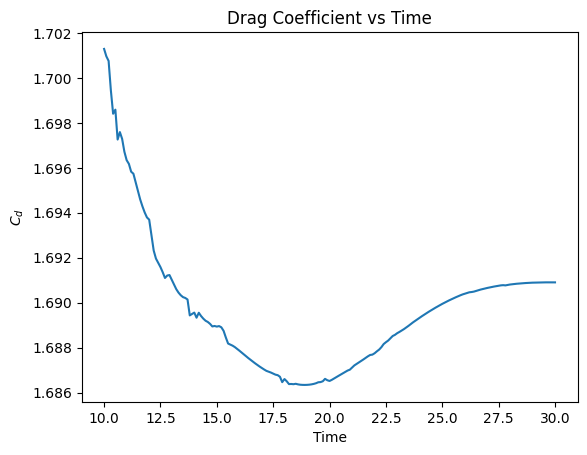

In [18]:
# Plot drag coefficient (Cd) vs time
plt.plot(data.iloc[100:, 0], data.iloc[100:, 2])
plt.xlabel("Time")
plt.ylabel("$C_d$")
plt.title("Drag Coefficient vs Time")
plt.grid(False)
plt.show()

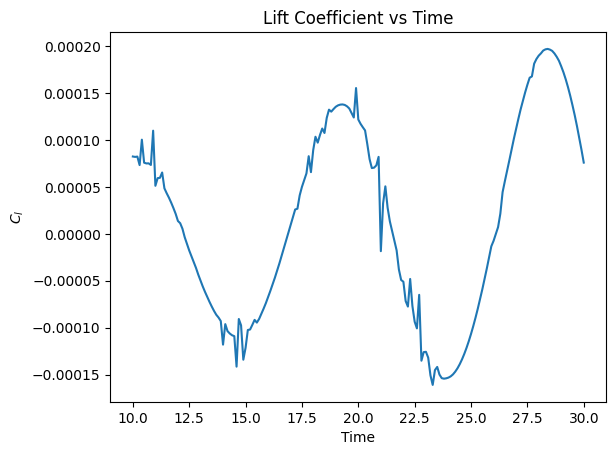

In [19]:
# Plot lift coefficient (Cl) vs time
plt.plot(data.iloc[100:, 0], data.iloc[100:, 3])
plt.xlabel("Time")
plt.ylabel("$C_l$")
plt.title("Lift Coefficient vs Time")
plt.grid(False)
plt.show()